In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek

%matplotlib inline

# Data Cleaning

In [2]:
all_complaints = pd.read_csv('data/DOB_Complaints_Received.csv')
print(list(all_complaints))
print(len(all_complaints))

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Complaint Number', 'Status', 'Date Entered', 'House Number', 'ZIP Code', 'House Street', 'BIN', 'Community Board', 'Special District', 'Complaint Category', 'Unit', 'Disposition Date', 'Disposition Code', 'Inspection Date', 'DOBRunDate']
2299448


### Handle types

In [3]:
all_complaints['Complaint Category'] = all_complaints['Complaint Category'].astype(str)

### Filter down to just Elevators

In [4]:
# complaint_categories = ['13', '62', '63', '80', '81']
complaint_categories = ['63']

elevator_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]

print("Number of total complaints: {}\n".format(len(all_complaints)))

print("Elevator complaint count by category:\n{}\n".format(elevator_complaints['Complaint Category'].value_counts()))

Number of total complaints: 2299448

Elevator complaint count by category:
63    148168
Name: Complaint Category, dtype: int64



### Inspections over time

Lengths after cleaning malformed dates: 148164


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


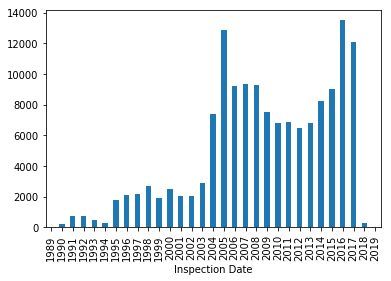

In [5]:
elevator_complaints['Inspection Date'] = pd.to_datetime(elevator_complaints['Inspection Date'],  errors='coerce')
elevator_complaints = elevator_complaints.dropna(subset=['Inspection Date'])
print("Lengths after cleaning malformed dates: {}".format(len(elevator_complaints)))

elevator_complaints.groupby(elevator_complaints['Inspection Date'].dt.year).count()['BIN'].plot(kind='bar')

# CHECK IF THERE ARE ELEVATOR COMPLAINTS IN THE 311 DATASET

### Remove duplicate complaints
TODO: or could this be a feature? Do multiple complaints from a building incrase the likely hood of it being a violation?

In [6]:
elevator_complaints = elevator_complaints.drop_duplicates(subset=['BIN', 'Date Entered'])
print("number of boiler complaints after dropping duplicates: {}".format(len(elevator_complaints)))

number of boiler complaints after dropping duplicates: 132897


### Filter down to relevant labels

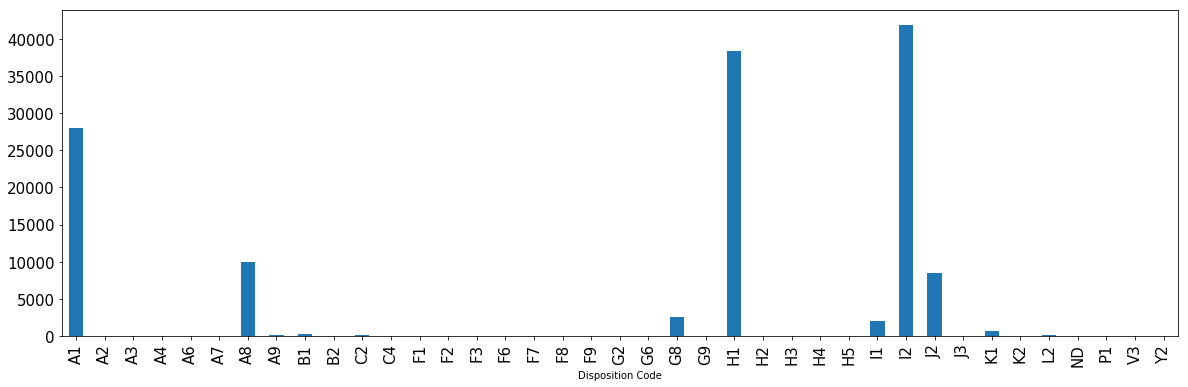

In [7]:
# print(boiler_complaints['Disposition Code'].value_counts())
elevator_complaints.groupby('Disposition Code').count()['BIN'].plot('bar', figsize=(20, 6), fontsize=15)

**Positive**: A8 (ECB Violation Served), A1 (Buildings Violation(s) Served)

**Negative**: I2 (No Violation Warranted for Complaint at Time of Inspection), I1 (Complaint Unsubstantiated Based on Department Records), 

**Note**: H1 (Please See Complaint Number) No documentation as to what this means. J2 (J1?: Follow-Up Inspection to be Scheduled Upon Further Research) No documentation for 'J2' but most likely J1.

In [8]:
positive_labels = ['A1', 'A8']
negative_labels = ['I1', 'I2']
elevator_complaints = elevator_complaints[elevator_complaints['Disposition Code'].isin(positive_labels + negative_labels)]
print("Number of complaints after filter down to relevant dispoisition codes: {}".format(len(elevator_complaints)))

Number of complaints after filter down to relevant dispoisition codes: 81757


# Create Labels

In [9]:
labels = elevator_complaints['Disposition Code'].isin(positive_labels) * 1

In [10]:
print("Percent of labels that are positive (result in violation): {}".format(sum(labels) / len(labels)))

Percent of labels that are positive (result in violation): 0.46388688430348474


# Create Features

In [11]:
elevator_complaints['Violation'] = labels

In [12]:
def violation_ratio_test(column):
    """ Will calculate the ratio of violation to complaints for each category of a given column."""
    return elevator_complaints.groupby(column)['Violation'].sum() / elevator_complaints.groupby(column).count()['Violation']

### Date Features

In [13]:
elevator_complaints['Date Entered'] = pd.to_datetime(elevator_complaints['Date Entered'])
elevator_complaints['Inspection Date'] = pd.to_datetime(elevator_complaints['Inspection Date'])

In [14]:
elevator_complaints['Day'] = elevator_complaints['Date Entered'].apply(lambda date: date.day)

In [15]:
elevator_complaints['Response Time'] = (elevator_complaints['Inspection Date'] - elevator_complaints['Date Entered']).dt.days
print("Length before response time clean: {}".format(len(elevator_complaints)))
elevator_complaints = elevator_complaints[elevator_complaints['Response Time'] >= 0]
print("Length after response time clean: {}".format(len(elevator_complaints)))

Length before response time clean: 81757
Length after response time clean: 81451


### Number of previous elevator complaints

In [16]:
complaint_counts = elevator_complaints.groupby('BIN').apply(lambda row: row['Date Entered'])

In [17]:
def get_previous_complaints(row):
    complaints = complaint_counts[row['BIN']]
#     print(len(complaints))
    return(len(complaints[complaints < row['Date Entered']]))

In [18]:
elevator_complaints['Previous Complaints'] = elevator_complaints.apply(get_previous_complaints, axis=1 )

In [19]:
violation_ratio_test('Previous Complaints').sort_values(ascending=False)

Previous Complaints
170    1.000000
137    1.000000
150    1.000000
151    1.000000
134    1.000000
131    1.000000
130    1.000000
129    1.000000
116    1.000000
157    1.000000
158    1.000000
159    1.000000
102    1.000000
162    1.000000
164    1.000000
165    1.000000
166    1.000000
168    1.000000
136    1.000000
83     0.833333
71     0.750000
89     0.666667
85     0.666667
56     0.647059
78     0.615385
94     0.600000
96     0.600000
52     0.580000
66     0.578947
59     0.571429
         ...   
143    0.000000
144    0.000000
145    0.000000
123    0.000000
110    0.000000
121    0.000000
107    0.000000
167    0.000000
163    0.000000
169    0.000000
161    0.000000
99     0.000000
100    0.000000
160    0.000000
104    0.000000
105    0.000000
106    0.000000
108    0.000000
120    0.000000
109    0.000000
111    0.000000
112    0.000000
113    0.000000
114    0.000000
115    0.000000
156    0.000000
117    0.000000
118    0.000000
119    0.000000
147    0.000000
Name

### Number of previous elevator violations

In [20]:
violation_counts = elevator_complaints.groupby('BIN').apply(lambda row: row[row['Violation'] == 1]['Date Entered'])

In [21]:
def get_previous_violations(row):
    try:
        violations = violation_counts[row['BIN']]
        return len(violations[violations < row['Date Entered']])
    except:
        return 0

In [22]:
elevator_complaints['Previous Violations'] = elevator_complaints.apply(lambda row: get_previous_violations(row), axis=1)

### Number of previous boiler violations / complaints ratio

In [23]:
elevator_complaints['Violation Ratio'] = (elevator_complaints['Previous Violations'] / elevator_complaints['Previous Complaints']).fillna(0)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio
5438,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,08/14/1991,A1,1991-08-05,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0
5460,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,10/19/1995,I2,1995-08-21,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0
5473,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,03/05/1992,A1,1992-03-05,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0
5491,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,08/11/1992,I2,1992-08-05,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0
5498,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,06/15/1990,A1,1990-06-12,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0


In [24]:
# print(elevator_complaints['Violation Ratio'].value_counts())
violation_ratio_test('Violation Ratio')

Violation Ratio
0.000000    0.399719
0.045455    0.000000
0.047619    0.500000
0.050000    0.250000
0.052632    0.250000
0.055556    0.333333
0.058824    0.142857
0.060606    1.000000
0.062500    0.400000
0.064516    0.000000
0.066667    0.333333
0.068966    0.000000
0.071429    0.192308
0.074074    0.000000
0.076923    0.230769
0.080000    0.333333
0.083333    0.280702
0.085714    0.000000
0.086957    0.000000
0.088235    0.500000
0.090909    0.265823
0.093023    1.000000
0.093750    0.000000
0.095238    0.090909
0.096774    0.000000
0.097561    0.000000
0.100000    0.242991
0.102041    1.000000
0.102564    0.000000
0.104167    0.000000
              ...   
0.851852    0.750000
0.852941    1.000000
0.857143    0.625310
0.861111    0.000000
0.862069    1.000000
0.863636    0.500000
0.866667    0.736842
0.869565    0.625000
0.870968    1.000000
0.875000    0.595331
0.880000    0.000000
0.882353    0.904762
0.888889    0.620253
0.894737    0.615385
0.900000    0.574257
0.904762    0.8333

### Number of other complaints

In [25]:
all_complaints['BIN'] = all_complaints['BIN'].astype(str)
elevator_complaints['BIN'] = elevator_complaints['BIN'].astype(str)

bin_to_complaint_counts = all_complaints['BIN'].value_counts()

def get_all_previous_complaints(row): 
    return (bin_to_complaint_counts[row['BIN']])

elevator_complaints['All Complaints'] = elevator_complaints.apply(lambda row: get_all_previous_complaints(row), axis=1)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,Disposition Code,Inspection Date,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio,All Complaints
5438,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,A1,1991-08-05,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0,22
5460,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,I2,1995-08-21,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0,47
5473,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,A1,1992-03-05,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0,56
5491,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,I2,1992-08-05,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0,45
5498,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,A1,1990-06-12,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0,49


# Building Features

### Bin to BBL

In [26]:
bin_to_bbl = pd.read_csv('data/pad19a/bobaadr.txt')

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
bin_to_bbl.head()

,boro,block,lot,bin,lhnd,lhns,lcontpar,lsos,hhnd,hhns,...,addrtype,realb7sc,validlgcs,dapsflag,naubflag,parity,b10sc,segid,zipcode,physical_id
0,1,1,10,1089249,,,,L,,,...,N,,01,,,0,10007401010,0132761,10004,
1,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077201010,0117705,10004,0138883
2,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077301010,0115073,10004,0175748
3,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077401010,0018085,10004,0097424
4,1,1,10,1000000,,,,R,,,...,N,,01,,,0,10077501010,0299272,10004,0174909


In [28]:
def format_bbl(row):
    boro = str(row['boro'])
    block = str(row['block'])
    lot = str(row['lot'])
    
    return boro + block.zfill(5) + lot.zfill(4)

In [29]:
bin_to_bbl['bbl'] = bin_to_bbl.apply(format_bbl, axis=1)

In [30]:
bin_to_bbl['bin'] = bin_to_bbl['bin'].astype(str)

elevator_complaints = pd.merge(elevator_complaints, bin_to_bbl[['bin', 'bbl']], left_on='BIN', right_on='bin', how='left').drop_duplicates(subset=['Complaint Number'])
print(elevator_complaints['bbl'].isna().value_counts())
elevator_complaints = elevator_complaints.dropna(subset=['bbl'])
print(elevator_complaints['bbl'].isna().value_counts())

False    80833
True       618
Name: bbl, dtype: int64
False    80833
Name: bbl, dtype: int64


In [31]:
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,DOBRunDate,Violation,Day,Response Time,Previous Complaints,Previous Violations,Violation Ratio,All Complaints,bin,bbl
0,1005878,CLOSED,1990-03-19,478,10025,CENTRAL PARK WEST,1055724,107,,63,...,11/07/2018 12:00:00 AM,1,19,504,0,0,0.0,22,1055724,1018441001
2,1005901,CLOSED,1990-03-20,540,10031,WEST 144 STREET,1061892,109,,63,...,11/07/2018 12:00:00 AM,0,20,1980,0,0,0.0,47,1061892,1020750049
3,1005914,CLOSED,1990-03-21,452,10031,WEST 149 STREET,1061526,109,,63,...,11/07/2018 12:00:00 AM,1,21,715,0,0,0.0,56,1061526,1020630054
4,1005933,CLOSED,1990-03-21,11,10027,WEST 123 STREET,1053424,110,,63,...,11/07/2018 12:00:00 AM,0,21,868,0,0,0.0,45,1053424,1017210045
5,1005940,CLOSED,1990-03-22,888,10019,8 AVENUE,1024825,105,,63,...,11/07/2018 12:00:00 AM,1,22,82,0,0,0.0,49,1024825,1010240001


### Merge With Pluto

In [32]:
pluto = pd.read_csv('data/pluto_more_features.csv')
list(pluto)

['exempttot',
 'address',
 'bbl',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'ownertype',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

In [33]:
# for col in list(pluto):
#     print(col)
#     print(pluto[col].isna().value_counts())
#     print()

In [34]:
pluto = pluto.drop(['ownertype'], axis=1)

In [35]:
pluto['bbl'] = pluto['bbl'].astype(str)
elevator_complaints = pd.merge(elevator_complaints, pluto, on='bbl', how='left')

In [36]:
print(elevator_complaints['yearbuilt'].isna().value_counts())
elevator_complaints = elevator_complaints.dropna()
print(elevator_complaints['yearbuilt'].isna().value_counts())

False    76394
True      4439
Name: yearbuilt, dtype: int64
False    76380
Name: yearbuilt, dtype: int64


# Model

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [38]:
list(elevator_complaints)

['Complaint Number',
 'Status',
 'Date Entered',
 'House Number',
 'ZIP Code',
 'House Street',
 'BIN',
 'Community Board',
 'Special District',
 'Complaint Category',
 'Unit',
 'Disposition Date',
 'Disposition Code',
 'Inspection Date',
 'DOBRunDate',
 'Violation',
 'Day',
 'Response Time',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'bin',
 'bbl',
 'exempttot',
 'address',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

### Select and Encode Features

In [39]:
categorical = ['ZIP Code', 'landuse', 'cb2010', 'bldgclass']

elevator_complaints[categorical] = elevator_complaints[categorical].apply(lambda col: col.astype('category').cat.codes)
elevator_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,bbl,exempttot,address,bldgclass,cb2010,assesstot,landuse,yearalter1,yearalter2,yearbuilt
1,1005901,CLOSED,1990-03-20,540,29,WEST 144 STREET,1061892,109,,63,...,1020750049,921600.0,540 WEST 144 STREET,23,106,921600.0,2,1989.0,0.0,1910.0
2,1005914,CLOSED,1990-03-21,452,29,WEST 149 STREET,1061526,109,,63,...,1020630054,771312.0,452 WEST 149 STREET,23,53,1242000.0,2,1987.0,0.0,1902.0
3,1005933,CLOSED,1990-03-21,11,25,WEST 123 STREET,1053424,110,,63,...,1017210045,0.0,15 WEST 123 STREET,23,54,646200.0,2,1988.0,0.0,1935.0
4,1005940,CLOSED,1990-03-22,888,17,8 AVENUE,1024825,105,,63,...,1010240001,0.0,870 8 AVENUE,28,54,34980750.0,3,0.0,0.0,1965.0
5,1005949,CLOSED,1990-03-22,60,3,EAST 11 STREET,1009105,102,,63,...,1005620014,0.0,60 EAST 11 STREET,90,53,3443400.0,5,0.0,0.0,1930.0


In [40]:
print(len(elevator_complaints))
elevator_complaints = elevator_complaints.dropna()
print(len(elevator_complaints))

76380
76380


In [41]:
### Select Features

In [104]:
included_features = [
 'ZIP Code',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'Day',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt',
 'exempttot',
 'bldgclass',
 'cb2010',
'BIN']

In [105]:
X = elevator_complaints[included_features]
y = elevator_complaints['Violation']

In [106]:
def group_train_test_splits(X, y, groups, test_size=0.15):
    gs = GroupShuffleSplit(n_splits=1, test_size=test_size).split(X, y, groups=groups)
    
#     X_train = None
#     X_test = None
#     y_train = None
#     y_test = None
    
    for ii, (train, test) in enumerate(gs):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
    return X_train, X_test, y_train, y_test

In [107]:
groups = elevator_complaints['BIN'].astype('category').cat.codes
X_train, X_test, y_train, y_test = group_train_test_splits(X, y, groups)

print("Training Data size: {}".format(len(X_train)))
print("Testing Data size: {}".format(len(X_test)))
print("Testing Data %: {}".format(len(X_test) / len(X_train)))
print(set(X_train['BIN']) & set(X_test['BIN']))
print()

Training Data size: 64819
Testing Data size: 11561
Testing Data %: 0.178358197442108
set()



In [108]:
groups = X_train['BIN'].astype('category').cat.codes

X_train, X_val, y_train, y_val = group_train_test_splits(X_train, y_train, groups)

print("Training Data size: {}".format(len(X_train)))
print("Validation Data size: {}".format(len(X_val)))
print("Testing Data size: {}".format(len(X_test)))
print("Validation Data %: {}".format(len(X_val) / len(X_train)))
print(set(X_train['BIN']) & set(X_val['BIN']) & set(X_test['BIN']))
print()
### BALANCE
print("training Data Balance: {}".format(y_train.sum() / len(y_train)))
print("val Data Balance: {}".format(y_val.sum() / len(y_val)))
print("test Data Balance: {}".format(y_test.sum() / len(y_test)))
X_train = X_train.drop(["BIN"], axis=1)
X_val = X_val.drop(["BIN"], axis=1)
X_test = X_test.drop(["BIN"], axis=1)

Training Data size: 54849
Validation Data size: 9970
Testing Data size: 11561
Validation Data %: 0.18177177341428286
set()

training Data Balance: 0.4659155135007019
val Data Balance: 0.4738214643931795
test Data Balance: 0.4654441657296082


### Plot train and test feature distributions

In [109]:
# for feature in list(X_train):
#     print(feature)
#     print("Training")
#     plt.hist(X_train[feature])
#     plt.show()
#     print("Val")
#     plt.hist(X_val[feature])
#     plt.show()    
#     print("Test")
#     plt.hist(X_test[feature])
#     plt.show()    

# Train Model

In [114]:
clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=None)
clf.fit(X_train, y_train)

# print("Testing Data Balance: {}".format(y_train.sum() / len(y_train)))
print("Training accuracy: {}".format(clf.score(X_train, y_train)))
# print("Val Data Balance: {}".format(y_test.sum() / len(y_test)))
print("Val accuracy: {}".format(clf.score(X_val, y_val)))
feature_importances = pd.DataFrame(clf.feature_importances_, list(X_train))

Training accuracy: 0.9513938266878157
Val accuracy: 0.5779338014042127


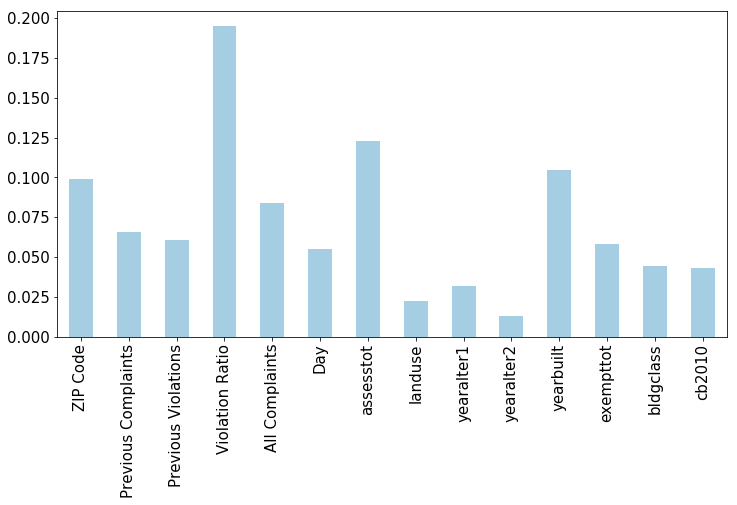

In [112]:
feature_importances.plot(kind='bar', legend=False, colormap='Paired', stacked=True, figsize=(12,6), fontsize=15)

# Metrics

In [99]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels

### ROC Curve

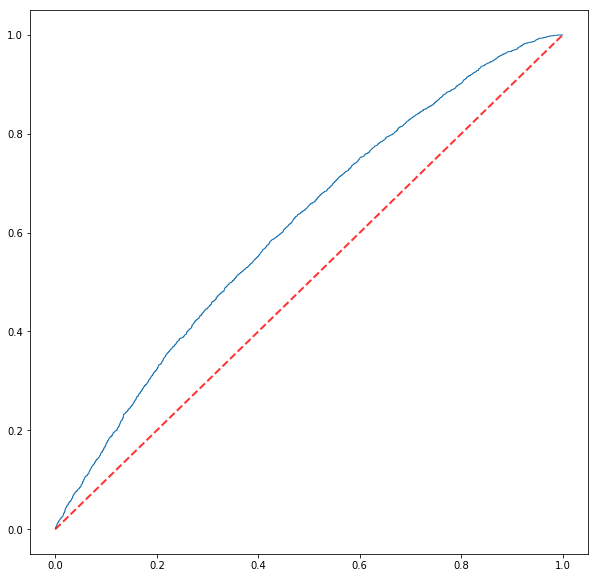

In [115]:
y_predict_probs = clf.predict_proba(X_val)
y_preds = clf.predict(X_val)
# print(clf.classes_)
# print(y_predict_probs)

fpr, tpr, thresholds = roc_curve(y_val, y_predict_probs[:,1])

roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))

plt.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

In [116]:
### Confusion Matrix

In [117]:
# Code frome: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    plt.figure(figsize=(15,15))
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    thresh = 0.5
    print(thresh)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[0 1]
Confusion matrix, without normalization
[[3130 2116]
 [2092 2632]]
0.5
[0 1]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.44 0.56]]
0.5


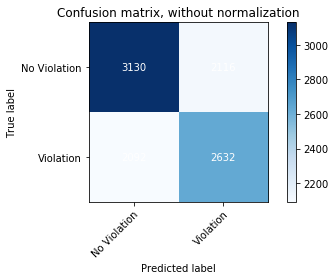

<Figure size 1080x1080 with 0 Axes>

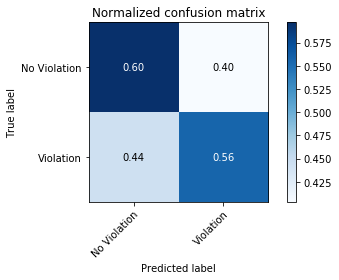

<Figure size 1080x1080 with 0 Axes>

In [118]:
np.set_printoptions(precision=2)

class_names = ['No Violation', 'Violation']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Holdout time interval for priority testing

In [774]:
priority_testing_threshold = 2012

print("Length of features before prioirty testing split {}".format(len(elevator_complaints)))
priority_testing_features = elevator_complaints[elevator_complaints['Date Entered'].dt.year >= priority_testing_threshold]
train_test_features = elevator_complaints[elevator_complaints['Date Entered'].dt.year < priority_testing_threshold]

print("Length of priority testing features {}".format(len(priority_testing_features)))
print("Length of training and testing_features {}".format(len(train_test_features)))

Length of features before prioirty testing split 76380
Length of priority testing features 23593
Length of training and testing_features 52787


### Select Features

In [813]:
included_features = [
 'ZIP Code',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'Day',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt',
 'exempttot',
 'bldgclass',
 'cb2010']

In [814]:
y = train_test_features['Violation']
X = train_test_features[included_features]

priority_testing_y = priority_testing_features['Violation']
priority_testing_X = priority_testing_features[included_features]

X.head()

,ZIP Code,Previous Complaints,Previous Violations,Violation Ratio,All Complaints,Day,assesstot,landuse,yearalter1,yearalter2,yearbuilt,exempttot,bldgclass,cb2010
1,29,0,0,0.0,47,20,921600.0,2,1989.0,0.0,1910.0,921600.0,23,106
2,29,0,0,0.0,56,21,1242000.0,2,1987.0,0.0,1902.0,771312.0,23,53
3,25,0,0,0.0,45,21,646200.0,2,1988.0,0.0,1935.0,0.0,23,54
4,17,0,0,0.0,49,22,34980750.0,3,0.0,0.0,1965.0,0.0,28,54
5,3,0,0,0.0,31,22,3443400.0,5,0.0,0.0,1930.0,0.0,90,53


### Resample

In [821]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

sum(y_smt) / len(y_smt)

0.5

### Create Train and test splits

In [822]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=None)
print(len(X_train))
print(len(X_test))

36864
9216


In [828]:
list(X)

['ZIP Code',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'All Complaints',
 'Day',
 'assesstot',
 'landuse',
 'yearalter1',
 'yearalter2',
 'yearbuilt',
 'exempttot',
 'bldgclass',
 'cb2010']

### Priority Score 2!

In [811]:
from statistics import mean

def accuracy_priority_score(scores_by_day):
    
    priorities = pd.DataFrame(list(scores_by_day.values))
    print("Average True positive Accuracy: {}".format(priorities[0].dropna().mean()))
    print("Average True Negative Accuracy: {}".format(priorities[1].dropna().mean()))

def day_priority_score(violations):
#     print(violations)
    number_of_violations = violations.sum()

    true_positive_accuracy = violations[:number_of_violations].sum() / number_of_violations
    true_negative_accuracy = (~violations[number_of_violations:].astype(bool)).sum() / (len(violations) - number_of_violations) 
    
    return [true_positive_accuracy, true_negative_accuracy]
    

In [812]:
# make predictions for priority set

priority_predictions = clf.predict(priority_testing_X)
priority_predictions_prob = clf.predict_proba(priority_testing_X)

print("Priority Testing balance: {}".format(priority_testing_y.sum() / len(priority_testing_y)))
print("Priority Testing accuracy: {}".format(clf.score(priority_testing_X, priority_testing_y)))
# priority_predictions
print(clf.classes_)
# print(priority_predictions_prob)

priority_testing_features['Priority'] = priority_predictions_prob[:,1]
# print(priority_predictions_prob[:,1])
# priority_testing_features.head()

Priority Testing balance: 0.514728945026067
Priority Testing accuracy: 0.5702962743186538
[0 1]


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [798]:
#### Random Score
random_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sample(frac=1)['Violation']))

print("\nRandom \n -------------------------")
accuracy_priority_score(random_by_day)
####

#### Baseline Score
baseline_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Response Time')['Violation']))

print("\nBaseline \n -------------------------")
accuracy_priority_score(baseline_by_day)
####

#### Model Score
model_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Priority', ascending=False)['Violation']))

print("\nModel\n -------------------------")
accuracy_priority_score(model_by_day)
####

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  



Random 
 -------------------------
Average True positive Accuracy: 0.5099373244630999
Average True Negative Accuracy: 0.5106351769269657

Baseline 
 -------------------------
Average True positive Accuracy: 0.5129806507297536
Average True Negative Accuracy: 0.5158890053906021

Model
 -------------------------
Average True positive Accuracy: 0.5919437803611599
Average True Negative Accuracy: 0.590429040084266
